In [31]:
import pandas as pd
import vectorbtpro as vbt


In [5]:
vbt.settings.plotting["layout"]["template"] = "vbt_dark"
vbt.settings.plotting["layout"]["width"] = 1200
vbt.settings.plotting['layout']['height'] = 600
vbt.settings.wrapping["freq"] = "1m"
# vbt.settings.portfolio['size_granularity'] = 0.001
vbt.settings.portfolio['init_cash'] = 10000

# Wherever you saved the pickle file
data_path = '/Users/ericervin/Documents/Coding/data-repository/data/BTCUSDT_1m.pkl'

In [11]:
# Read in the 1m BTC data from pickle
data = vbt.BinanceData.load(data_path)
btc_1m = data.get()
futures_1m = pd.read_csv('BTCUSDT-1m-2023-01.csv', index_col=0, parse_dates=True)

/var/folders/dt/m1bsm13n187d7m0ssssp79ww0000gn/T/ipykernel_3299/1745051394.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  futures_1m = pd.read_csv('BTCUSDT-1m-2023-01.csv', index_col=0, parse_dates=True)


In [13]:
# Change timestamp to datetime
futures_1m.index = pd.to_datetime(futures_1m.index, unit='ms')

In [15]:
futures_1m

,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
open_time,,,,,,,,,,,
2023-01-01 00:00:00,16537.5,16538.0,16534.3,16538.0,170.576,1672531259999,2.820697e+06,946,103.782,1.716165e+06,0
2023-01-01 00:01:00,16538.0,16538.0,16534.9,16534.9,44.287,1672531319999,7.323633e+05,570,19.098,3.158178e+05,0
2023-01-01 00:02:00,16534.9,16535.0,16531.3,16531.4,100.228,1672531379999,1.657072e+06,456,21.026,3.476265e+05,0
2023-01-01 00:03:00,16531.4,16531.4,16526.6,16526.9,317.879,1672531439999,5.254048e+06,980,79.937,1.321185e+06,0
2023-01-01 00:04:00,16527.0,16529.3,16523.0,16529.2,211.281,1672531499999,3.491635e+06,1113,79.049,1.306280e+06,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-01-31 23:55:00,23144.0,23150.0,23141.7,23145.6,276.408,1675209359999,6.398103e+06,1551,138.505,3.206134e+06,0
2023-01-31 23:56:00,23145.6,23145.7,23124.6,23127.0,198.219,1675209419999,4.585999e+06,1494,41.574,9.618180e+05,0
2023-01-31 23:57:00,23126.9,23136.0,23124.6,23133.6,149.375,1675209479999,3.455507e+06,919,62.368,1.442706e+06,0


In [17]:
day = '2023-01-08'
futures_1m.loc[day:'2023-01-09']['close'].vbt.plot().show()

In [18]:
def add_support_resistance(df: pd.DataFrame, 
                           Close_col: str = 'Close', 
                           stdev_lbw: str = '30D', 
                           low_sigma: int = 1, 
                           high_sigma: int = 6, 
                           sigma_step: int = 1) -> pd.DataFrame:
    
    # Calculate rolling 1D standard deviation of Close prices
    std_dev = df[Close_col].rolling('1D').std()
    # Take the stdev_lbw-day rolling average of the 1D standard deviations
    df['avg_rolling_stddev'] = std_dev.rolling(stdev_lbw).mean()
    df['fixed_daily_stddev'] = df['avg_rolling_stddev'].at_time('00:00')
    df['fixed_daily_stddev'] = df['fixed_daily_stddev'].ffill()
    df['open_line'] = df[Close_col].at_time('00:00')
    df['open_line'] = df['open_line'].ffill()

    for sigma in range(low_sigma, high_sigma+1, sigma_step):
        df[f'daily_support_{sigma}'] = df['open_line'] - (df['fixed_daily_stddev'] * sigma)
        df[f'daily_support_{sigma}'] = df[f'daily_support_{sigma}'].ffill()

        df[f'daily_resistance_{sigma}'] = df['open_line'] + (df['fixed_daily_stddev'] * sigma)
        df[f'daily_resistance_{sigma}'] = df[f'daily_resistance_{sigma}'].ffill()
        
    return df

In [19]:
futures_w_sigmas = add_support_resistance(futures_1m, Close_col='close', stdev_lbw='30D', low_sigma=1, high_sigma=6, sigma_step=1)

In [23]:
futures_w_sigmas.loc[day:'2023-01-09'][['close','open_line', 'daily_support_1', 'daily_resistance_1', 'daily_support_3', 'daily_resistance_3']].vbt.plot().show()

## Create Functions 

The the next functions create dollar bars so you can manipulate and work with them and then the last function reverses that so you can merge the dollar bars back into a different time resolution.

In [29]:
import pandas as pd

def dollar_bar_func(ohlc_df, dollar_bar_size):
    # Calculate dollar value traded for each row
    ohlc_df['DollarValue'] = ohlc_df['Close'] * ohlc_df['Volume']
    
    # Calculate cumulative dollar value
    ohlc_df['CumulativeDollarValue'] = ohlc_df['DollarValue'].cumsum()
    
    # Determine the number of dollar bars
    num_bars = int(ohlc_df['CumulativeDollarValue'].iloc[-1] / dollar_bar_size)
    
    # Generate index positions for dollar bars
    bar_indices = [0]
    cumulative_value = 0
    for i in range(1, len(ohlc_df)):
        cumulative_value += ohlc_df['DollarValue'].iloc[i]
        if cumulative_value >= dollar_bar_size:
            bar_indices.append(i)
            cumulative_value = 0
    
    # Create a new dataframe with dollar bars
    dollar_bars = []
    for i in range(len(bar_indices) - 1):
        start_idx = bar_indices[i]
        end_idx = bar_indices[i + 1]
        
        dollar_bar = {
            'Open': ohlc_df['Open'].iloc[start_idx],
            'High': ohlc_df['High'].iloc[start_idx:end_idx].max(),
            'Low': ohlc_df['Low'].iloc[start_idx:end_idx].min(),
            'Close': ohlc_df['Close'].iloc[end_idx],
            'Volume': ohlc_df['Volume'].iloc[start_idx:end_idx].sum(),
            'Quote volume': ohlc_df['Quote volume'].iloc[start_idx:end_idx].sum(),
            'Trade count': ohlc_df['Trade count'].iloc[start_idx:end_idx].sum(),
            'Taker base volume': ohlc_df['Taker base volume'].iloc[start_idx:end_idx].sum(),
            'Taker quote volume': ohlc_df['Taker quote volume'].iloc[start_idx:end_idx].sum()
        }
        
        if isinstance(ohlc_df.index, pd.DatetimeIndex):
            dollar_bar['Open Time'] = ohlc_df.index[start_idx]
            dollar_bar['Close Time'] = ohlc_df.index[end_idx] - pd.Timedelta(milliseconds=1)
        elif 'Open Time' in ohlc_df.columns:
            dollar_bar['Open Time'] = ohlc_df['Open Time'].iloc[start_idx]
            dollar_bar['Close Time'] = ohlc_df['Open Time'].iloc[end_idx] - pd.Timedelta(milliseconds=1)
        
        dollar_bars.append(dollar_bar)
    
    dollar_bars_df = pd.concat([pd.DataFrame([bar]) for bar in dollar_bars], ignore_index=True)
    
    return dollar_bars_df

# Create a simple function to simplify the number so we can use it in our column names
def simplify_number(num):
    """
    Simplifies a large number by converting it to a shorter representation with a suffix (K, M, B).
    simplify_number(1000) -> 1K
    """
    suffixes = ['', 'K', 'M', 'B']
    suffix_index = 0

    while abs(num) >= 1000 and suffix_index < len(suffixes) - 1:
        num /= 1000.0
        suffix_index += 1

    suffix = suffixes[suffix_index] if suffix_index > 0 else ''
    simplified_num = f'{int(num)}{suffix}'

    return simplified_num

def merge_and_fill_dollar_bars(original_df, dollar_bars_df, dollar_bar_size):
    # Add prefix to column names in dollar bars dataframe
    dollar_bar_prefix = f'db_{simplify_number(dollar_bar_size)}_'
    dollar_bars_df_renamed = dollar_bars_df.add_prefix(dollar_bar_prefix)

    # Convert 'Open Time' columns to pandas datetime format and set them as index
    dollar_bars_df_renamed.index = pd.to_datetime(dollar_bars_df_renamed[dollar_bar_prefix + 'Open Time'])

    # Merge the dataframes on the index
    merged_df = original_df.merge(dollar_bars_df_renamed, how='left', left_index=True, right_index=True)

    # Set the flag for a new dollar bar with prefix
    merged_df[dollar_bar_prefix + 'NewDBFlag'] = ~merged_df[dollar_bar_prefix + 'Close'].isna()

    # Forward fill the NaN values for all columns except the new dollar bar flag
    columns_to_ffill = [col for col in merged_df.columns if col != dollar_bar_prefix + 'NewDBFlag']
    merged_df[columns_to_ffill] = merged_df[columns_to_ffill].fillna(method='ffill')

    # Fill the remaining NaN values in the new dollar bar flag column with False
    merged_df[dollar_bar_prefix + 'NewDBFlag'] = merged_df[dollar_bar_prefix + 'NewDBFlag'].fillna(False)
    
    # Assign the renamed 'Open Time' column back to the dataframe
    merged_df[dollar_bar_prefix + 'Open Time'] = merged_df[dollar_bar_prefix + 'Open Time']

    return merged_df





# Create dollar bars

In [30]:
dollar_bar_size = 90_000_000
btc_dollar_bars = dollar_bar_func(futures_1m, dollar_bar_size=dollar_bar_size)
btc_dollar_bars.shape

KeyError: 'Close'

Add a bunch of technical indicators In this case I'm adding all of the "momentum" indicators from pandas ta library

In [8]:
import pandas_ta as ta
# Append all of the different indicators in the talib library to the dollarbar dataframe.
btc_dollar_bars.ta.strategy(ta.Strategy("Momentum"), append=True)

[X] Strategy requires the following argument(s):
 - ta. Format is a list of dicts. Example: [{'kind': 'sma', 'length': 10}]
       Check the indicator for the correct arguments if you receive this error.


39it [00:08,  4.72it/s]


In [9]:
btc_dollar_bars.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote volume', 'Trade count',
       'Taker base volume', 'Taker quote volume', 'Open Time', 'Close Time',
       'AO_5_34', 'APO_12_26', 'BIAS_SMA_26', 'BOP', 'AR_26', 'BR_26',
       'CCI_14_0.015', 'CFO_9', 'CG_10', 'CMO_14', 'COPC_11_14_10', 'CTI_12',
       'ER_10', 'BULLP_13', 'BEARP_13', 'FISHERT_9_1', 'FISHERTs_9_1',
       'INERTIA_20_14', 'K_9_3', 'D_9_3', 'J_9_3',
       'KST_10_15_20_30_10_10_10_15', 'KSTs_9', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'MOM_10', 'PGO_14', 'PPO_12_26_9',
       'PPOh_12_26_9', 'PPOs_12_26_9', 'PSL_12', 'PVO_12_26_9', 'PVOh_12_26_9',
       'PVOs_12_26_9', 'QQE_14_5_4.236', 'QQE_14_5_4.236_RSIMA',
       'QQEl_14_5_4.236', 'QQEs_14_5_4.236', 'ROC_10', 'RSI_14', 'RSX_14',
       'RVGI_14_4', 'RVGIs_14_4', 'SLOPE_1', 'SMI_5_20_5', 'SMIs_5_20_5',
       'SMIo_5_20_5', 'SQZ_20_2.0_20_1.5', 'SQZ_ON', 'SQZ_OFF', 'SQZ_NO',
       'SQZPRO_20_2.0_20_2_1.5_1', 'SQZPRO_ON_WIDE', 'SQZPRO_ON_

Now recreate the original dataframe with 1 minute candles but all of the indicators built on dollar bars. the values will be forward filled to prevent any data leakage.

In [10]:
# now merge the two dataframes
btc_1m_with_dollar_bars = merge_and_fill_dollar_bars(btc_1m, btc_dollar_bars, dollar_bar_size=dollar_bar_size)

Print the columns to make sure it worked. Note the `db_` prefix 

In [11]:
btc_1m_with_dollar_bars.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote volume', 'Trade count',
       'Taker base volume', 'Taker quote volume', 'DollarValue',
       'CumulativeDollarValue', 'db_30M_Open', 'db_30M_High', 'db_30M_Low',
       'db_30M_Close', 'db_30M_Volume', 'db_30M_Quote volume',
       'db_30M_Trade count', 'db_30M_Taker base volume',
       'db_30M_Taker quote volume', 'db_30M_Open Time', 'db_30M_Close Time',
       'db_30M_AO_5_34', 'db_30M_APO_12_26', 'db_30M_BIAS_SMA_26',
       'db_30M_BOP', 'db_30M_AR_26', 'db_30M_BR_26', 'db_30M_CCI_14_0.015',
       'db_30M_CFO_9', 'db_30M_CG_10', 'db_30M_CMO_14', 'db_30M_COPC_11_14_10',
       'db_30M_CTI_12', 'db_30M_ER_10', 'db_30M_BULLP_13', 'db_30M_BEARP_13',
       'db_30M_FISHERT_9_1', 'db_30M_FISHERTs_9_1', 'db_30M_INERTIA_20_14',
       'db_30M_K_9_3', 'db_30M_D_9_3', 'db_30M_J_9_3',
       'db_30M_KST_10_15_20_30_10_10_10_15', 'db_30M_KSTs_9',
       'db_30M_MACD_12_26_9', 'db_30M_MACDh_12_26_9', 'db_30M_MACDs_12_26_9',
       'db

Check the shape of the frames to make sure they make sense

In [12]:


print(btc_1m.shape) # Original 1 minute price dataframe
print(btc_dollar_bars.shape) # Dollar bars dataframe
print(btc_1m_with_dollar_bars.shape) # Merged dataframe
print(btc_1m_with_dollar_bars['db_30M_NewDBFlag'].sum()) # Number of dollar bars in merged dataframe

(1262872, 11)
(91764, 82)
(1262872, 94)
91764


In [13]:
# Now do this with 90 million dollar bars and append them to the frame as well
dollar_bar_size = 90_000_000
btc_dollar_bars = dollar_bar_func(btc_1m, dollar_bar_size=dollar_bar_size)
btc_dollar_bars.ta.strategy(ta.Strategy("Momentum"), append=True)
btc_dollar_bars.shape

[X] Strategy requires the following argument(s):
 - ta. Format is a list of dicts. Example: [{'kind': 'sma', 'length': 10}]
       Check the indicator for the correct arguments if you receive this error.


39it [00:03, 12.13it/s]


(32490, 82)

In [14]:
# Merge the two dataframes
btc_1m_with_dollar_bars = merge_and_fill_dollar_bars(btc_1m_with_dollar_bars, btc_dollar_bars, dollar_bar_size=dollar_bar_size)


In [15]:
print(btc_1m.shape) # Original 1 minute price dataframe
print(btc_dollar_bars.shape) # Dollar bars dataframe
print(btc_1m_with_dollar_bars.shape) # Merged dataframe
print(btc_1m_with_dollar_bars['db_30M_NewDBFlag'].sum()) # Number of 30M dollar bars in merged dataframe
print(btc_1m_with_dollar_bars['db_90M_NewDBFlag'].sum()) # Number of 90M dollar bars in merged dataframe

(1262872, 11)
(32490, 82)
(1262872, 177)
91764
32490


<Axes: title={'center': 'BTC/USDT Dollar Bars'}, xlabel='Open time'>

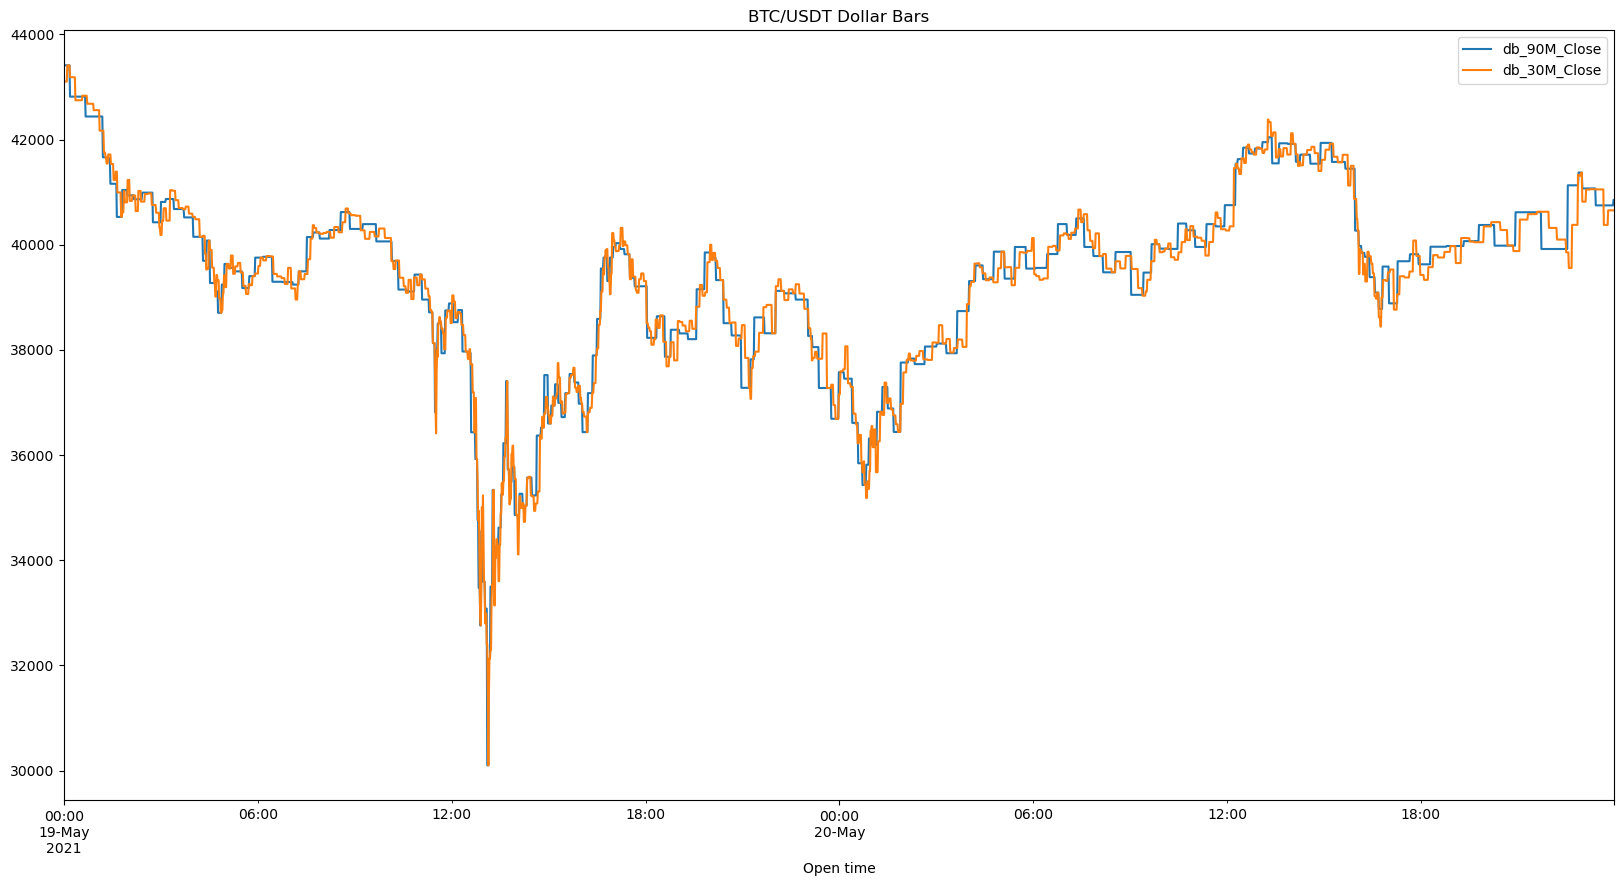

In [16]:
btc_1m_with_dollar_bars.loc['2021-05-19':'2021-05-20'][['db_90M_Close','db_30M_Close']].plot(figsize=(20, 10), title='BTC/USDT Dollar Bars')

In [17]:
btc_1m_with_dollar_bars.columns.to_list()

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Quote volume',
 'Trade count',
 'Taker base volume',
 'Taker quote volume',
 'DollarValue',
 'CumulativeDollarValue',
 'db_30M_Open',
 'db_30M_High',
 'db_30M_Low',
 'db_30M_Close',
 'db_30M_Volume',
 'db_30M_Quote volume',
 'db_30M_Trade count',
 'db_30M_Taker base volume',
 'db_30M_Taker quote volume',
 'db_30M_Open Time',
 'db_30M_Close Time',
 'db_30M_AO_5_34',
 'db_30M_APO_12_26',
 'db_30M_BIAS_SMA_26',
 'db_30M_BOP',
 'db_30M_AR_26',
 'db_30M_BR_26',
 'db_30M_CCI_14_0.015',
 'db_30M_CFO_9',
 'db_30M_CG_10',
 'db_30M_CMO_14',
 'db_30M_COPC_11_14_10',
 'db_30M_CTI_12',
 'db_30M_ER_10',
 'db_30M_BULLP_13',
 'db_30M_BEARP_13',
 'db_30M_FISHERT_9_1',
 'db_30M_FISHERTs_9_1',
 'db_30M_INERTIA_20_14',
 'db_30M_K_9_3',
 'db_30M_D_9_3',
 'db_30M_J_9_3',
 'db_30M_KST_10_15_20_30_10_10_10_15',
 'db_30M_KSTs_9',
 'db_30M_MACD_12_26_9',
 'db_30M_MACDh_12_26_9',
 'db_30M_MACDs_12_26_9',
 'db_30M_MOM_10',
 'db_30M_PGO_14',
 'db_30M_PPO_12_26_9',
 

<Axes: title={'center': 'BTC/USDT 30M and 90M Close'}, xlabel='Open time'>

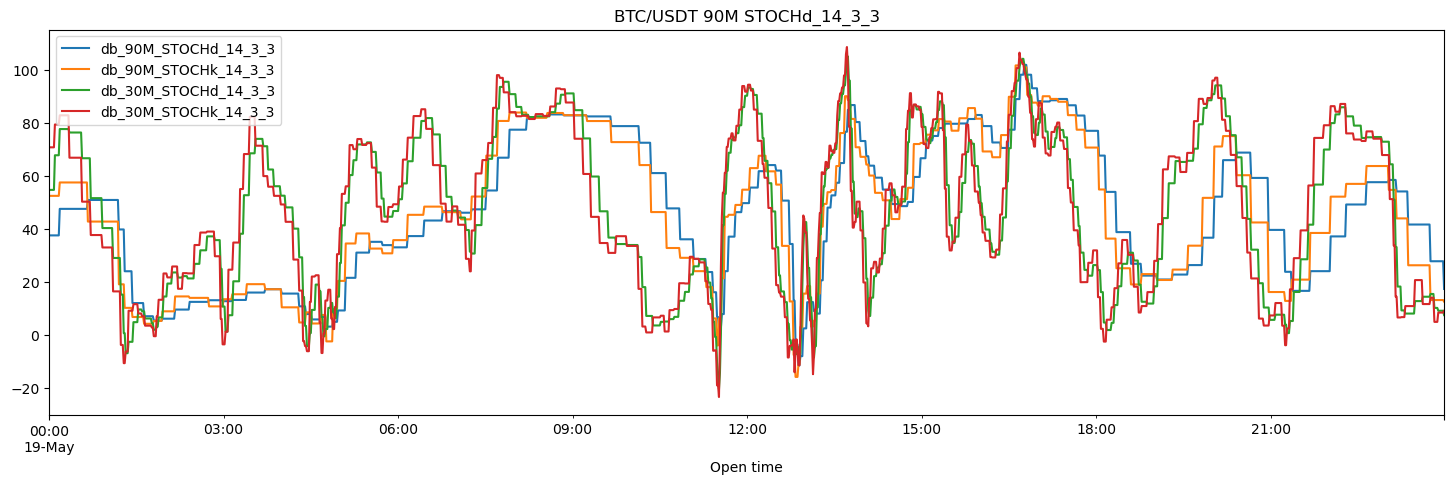

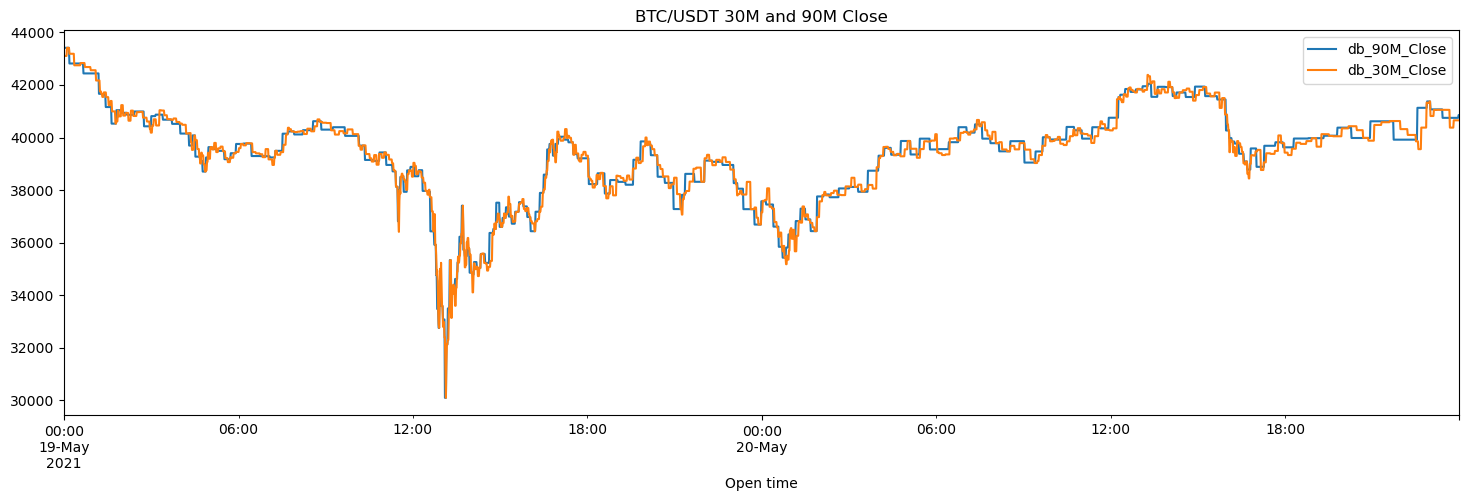

In [18]:
# Plot the 'STOCHd_14_3_3'
start = '2021-05-19'
end = '2021-05-20'
btc_1m_with_dollar_bars.loc[start][['db_90M_STOCHd_14_3_3','db_90M_STOCHk_14_3_3','db_30M_STOCHd_14_3_3','db_30M_STOCHk_14_3_3']].plot(figsize=(18, 5), title='BTC/USDT 90M STOCHd_14_3_3')
# Plot the price
btc_1m_with_dollar_bars.loc[start:end][['db_90M_Close','db_30M_Close']].plot(figsize=(18, 5), title='BTC/USDT 30M and 90M Close')

In [19]:
# Calculate the bar run how many up bars +1 and how many down bars -1 sums them up
def calculate_up_down_bar_series(series, window=None): # window is the rolling window None means use the entire series
    # Calculate the difference between current and previous bar
    diff = series.diff()

    # Map the difference to -1, 0, or 1
    up_down_bar_series = diff.apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))

    # Calculate the cumulative sum or the rolling sum based on the window value
    if window is None:
        up_down_bar_series = up_down_bar_series.cumsum()
    else:
        up_down_bar_series = up_down_bar_series.rolling(window).sum()

    return up_down_bar_series

In [20]:
# Calculate the bar run series for 30M and 90M dollar bars
bar_run_90M = calculate_up_down_bar_series(btc_1m_with_dollar_bars['db_90M_Close'], window=None)
bar_run_30M = calculate_up_down_bar_series(btc_1m_with_dollar_bars['db_30M_Close'], window=None)
bar_run_1min_close = calculate_up_down_bar_series(btc_1m_with_dollar_bars['Close'], window=None)
print(f'The high for the price of BTC over this period was ${btc_1m_with_dollar_bars["Close"].max():,.2f}')
print(f'The low for the price of BTC over this period was ${btc_1m_with_dollar_bars["Close"].min():,.2f}')
print(f'The start date was {btc_1m_with_dollar_bars.index.min()}, the end date was {btc_1m_with_dollar_bars.index.max()}')
print(f'The following table describes the bar run for 30M and 90M dollar bars and the 1 minute close')
# Concat the statistics into a dataframe for easy viewing
pd.set_option('display.float_format', lambda x: '%.0f' % x)
bar_run_stats = pd.concat([bar_run_90M.describe(), bar_run_30M.describe(), bar_run_1min_close.describe()], axis=1)
bar_run_stats.columns = ['90M', '30M', '1M']
bar_run_stats


The high for the price of BTC over this period was $69,000.00
The low for the price of BTC over this period was $15,513.84
The start date was 2021-01-01 00:00:00+00:00, the end date was 2023-05-28 17:44:00+00:00
The following table describes the bar run for 30M and 90M dollar bars and the 1 minute close


,90M,30M,1M
count,1262872,1262872,1262872
mean,74,85,-2970
std,85,96,1676
min,-51,-129,-5454
25%,15,22,-4550
50%,46,76,-3170
75%,99,170,-1604
max,292,343,239


<Axes: >

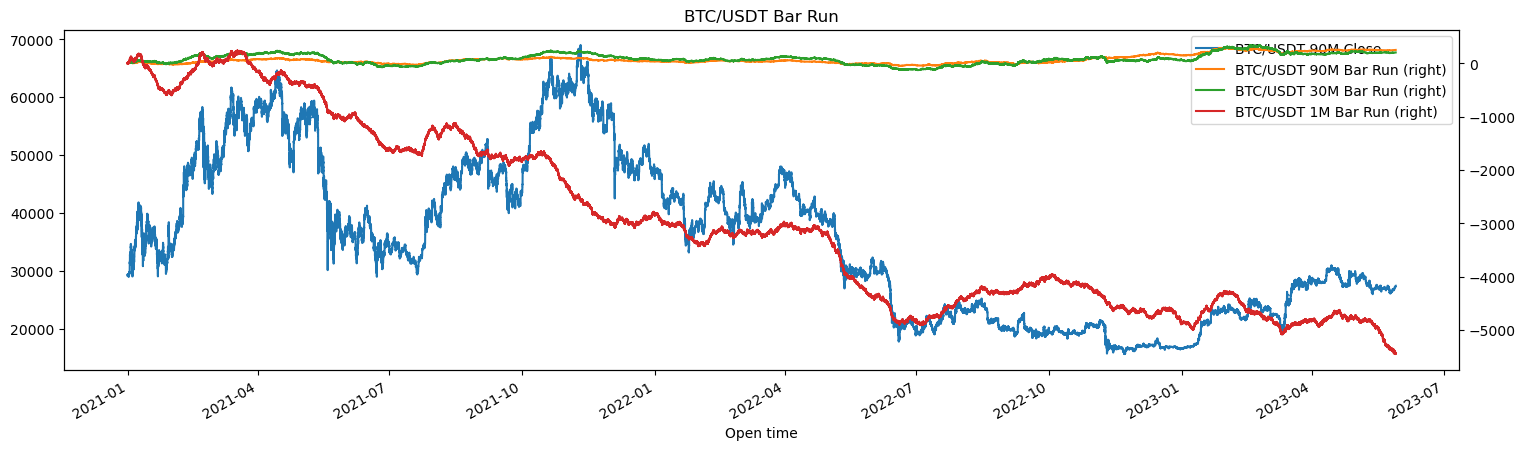

In [21]:
# Plot a histogram
# bar_run_90M.hist(bins=100, figsize=(18, 5))
btc_1m_with_dollar_bars['db_90M_Close'].plot(figsize=(18, 5), label='BTC/USDT 90M Close', legend=True)
bar_run_90M.plot(figsize=(18, 5), label='BTC/USDT 90M Bar Run', secondary_y=True, legend=True)
bar_run_30M.plot(figsize=(18, 5), title='BTC/USDT Bar Run', label='BTC/USDT 30M Bar Run', secondary_y=True, legend=True)
bar_run_1min_close.plot(figsize=(18, 5), label='BTC/USDT 1M Bar Run', secondary_y=True, legend=True)

This is pretty informative. Look at the average minute bar run it is -2970 means we spent on average over this whole timeframe with a negative 3000 as our minute bar count. But when you look at the dollar bar run counts they averaged positive numbers. 

In [22]:
# Let's look at rolling bar runs
# Calculate the bar run series for 30M and 90M dollar bars
bar_run_90M = calculate_up_down_bar_series(btc_1m_with_dollar_bars['db_90M_Close'], window=1440*7) # Rolling 7 day window
bar_run_30M = calculate_up_down_bar_series(btc_1m_with_dollar_bars['db_30M_Close'], window=1440*7) # Rolling 7 day window
bar_run_1min_close = calculate_up_down_bar_series(btc_1m_with_dollar_bars['Close'], window=1440*7) # Rolling 7 day window
print(f'The high for the price of BTC over this period was ${btc_1m_with_dollar_bars["Close"].max():,.2f}')
print(f'The low for the price of BTC over this period was ${btc_1m_with_dollar_bars["Close"].min():,.2f}')
print(f'The start date was {btc_1m_with_dollar_bars.index.min()}, the end date was {btc_1m_with_dollar_bars.index.max()}')
print(f'The following table describes the bar run for 30M and 90M dollar bars and the 1 minute close')
# Concat the statistics into a dataframe for easy viewing
pd.set_option('display.float_format', lambda x: '%.0f' % x)
bar_run_stats = pd.concat([bar_run_90M.describe(), bar_run_30M.describe(), bar_run_1min_close.describe()], axis=1)
bar_run_stats.columns = ['90M', '30M', '1M']
bar_run_stats


The high for the price of BTC over this period was $69,000.00
The low for the price of BTC over this period was $15,513.84
The start date was 2021-01-01 00:00:00+00:00, the end date was 2023-05-28 17:44:00+00:00
The following table describes the bar run for 30M and 90M dollar bars and the 1 minute close


,90M,30M,1M
count,1252793,1252793,1252793
mean,2,1,-44
std,17,34,146
min,-73,-141,-539
25%,-9,-17,-138
50%,1,0,-40
75%,13,22,57
max,77,118,522


<Axes: >

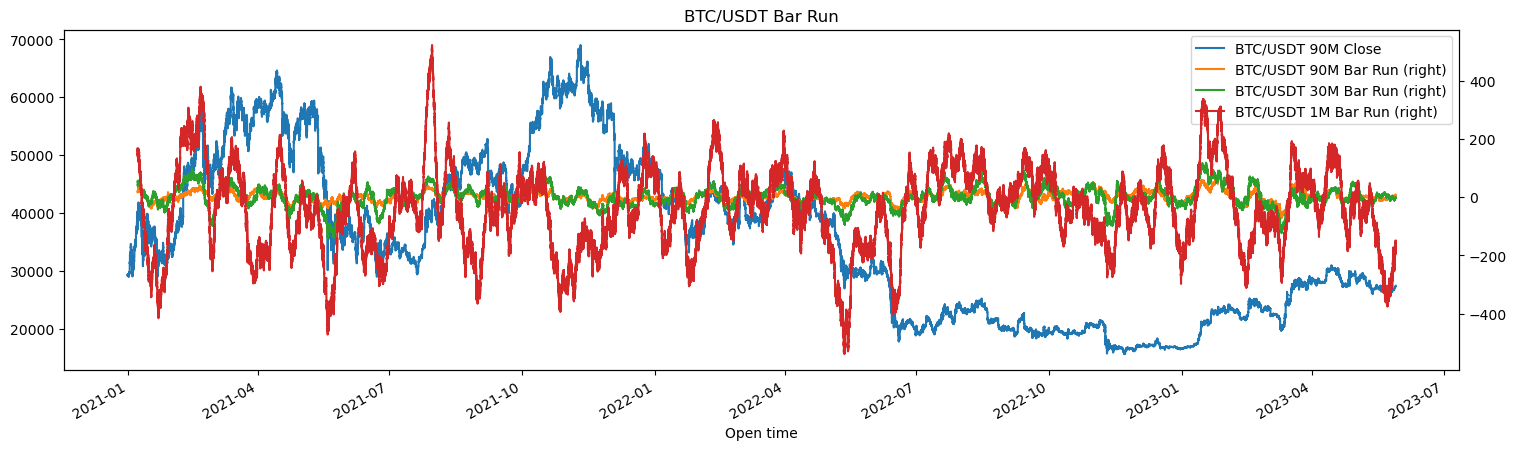

In [23]:
# Plot the rolling bar runs
btc_1m_with_dollar_bars['db_90M_Close'].plot(figsize=(18, 5), label='BTC/USDT 90M Close', legend=True)
bar_run_90M.plot(figsize=(18, 5), label='BTC/USDT 90M Bar Run', secondary_y=True, legend=True)
bar_run_30M.plot(figsize=(18, 5), title='BTC/USDT Bar Run', label='BTC/USDT 30M Bar Run', secondary_y=True, legend=True)
bar_run_1min_close.plot(figsize=(18, 5), label='BTC/USDT 1M Bar Run', secondary_y=True, legend=True)

In [24]:
# Use vectorbt to plot these bar runs for interctive plots

import plotly.graph_objs as go
resample_period = '1D'

# Initialize a figure
fig = go.Figure()

# Add the first trace to the figure, plotted on the left y-axis
fig.add_trace(go.Scatter(x=btc_1m_with_dollar_bars.index.resample(resample_period).last(), 
                         y=btc_1m_with_dollar_bars.resample(resample_period)['db_90M_Close'].last(), 
                         mode='lines', 
                         name='db_90M_Close'))

# Add the second trace to the figure, plotted on the right y-axis
fig.add_trace(go.Scatter(x=bar_run_90M.index.resample(resample_period).last(), 
                         y=bar_run_90M.resample(resample_period).last(), 
                         mode='lines', 
                         name='bar_run_90M',
                         yaxis='y2'))

# Add the third trace to the figure, also plotted on the right y-axis
fig.add_trace(go.Scatter(x=bar_run_30M.index.resample(resample_period).last(), 
                         y=bar_run_30M.resample(resample_period).last(), 
                         mode='lines', 
                         name='bar_run_30M',
                         yaxis='y2'))

# Add the fourth trace to the figure, also plotted on the right y-axis
fig.add_trace(go.Scatter(x=bar_run_1min_close.index.resample(resample_period).last(), 
                         y=bar_run_1min_close.resample(resample_period).last(), 
                         mode='lines', 
                         name='bar_run_1min_close',
                         yaxis='y2'))

# Update the layout to add a second y-axis to the right of the plot
fig.update_layout(
    yaxis=dict(title='db_90M_Close'),
    yaxis2=dict(title='Runs', 
                overlaying='y', 
                side='right'))

fig.show()




AttributeError: 'DatetimeIndex' object has no attribute 'resample'

In [ ]:
pd.reset_option('display.float_format')

In [ ]:
# Get the last item in the series
bar_run_series[-1]

NameError: name 'bar_run_series' is not defined